In [1]:
import sys
import os
# Add 'src' directory to Python path
src_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
if src_path not in sys.path:
    sys.path.append(src_path)

In [2]:

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from src import schema as sc   # your custom schema function
from src import datacleaning as dcp
from src import kpi_analysis as kpi
from src import franchise_analysis as franch
from src import visualisation as visn
from pyspark.sql.types import *
from pyspark.sql.functions import * 



### Fetching the data

In [ ]:
# Initialize Spark
spark = SparkSession.builder.appName("TMDB Movies").getOrCreate()

# Load JSON data using the schema
json_path = "/Users/gyauk/github/labs/Pyspark_IMBD_movie_analysis/data/raw/movies.json"
df = spark.read.schema(sc.schema_build()).json(json_path)


25/04/24 08:04:20 WARN Utils: Your hostname, Gyaus-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.0.106 instead (on interface en0)
25/04/24 08:04:20 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/24 08:04:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
df.show(5)

+------+--------------------+--------------------+------------+-----------------+---------+----------+----------+------------+----------+-------+--------------------+--------------------+---------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|    id|               title|             tagline|release_date|original_language|   budget|   revenue|vote_count|vote_average|popularity|runtime|            overview|         poster_path|belongs_to_collection|              genres|production_companies|production_countries|    spoken_languages|             credits|
+------+--------------------+--------------------+------------+-----------------+---------+----------+----------+------------+----------+-------+--------------------+--------------------+---------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|299534|   Avengers: Endgame|  Avenge the fallen.|  201

### Data Preparation & Cleaning

### Drop Irrelevant Columns

In [ ]:
# Drop columns 
cols_to_drop = ['adult', 'imdb_id', 'original_title', 'video', 'homepage']
df = df.drop(*cols_to_drop)

['id',
 'title',
 'tagline',
 'release_date',
 'original_language',
 'budget',
 'revenue',
 'vote_count',
 'vote_average',
 'popularity',
 'runtime',
 'overview',
 'poster_path',
 'belongs_to_collection',
 'genres',
 'production_companies',
 'production_countries',
 'spoken_languages',
 'credits']

In [6]:
# Check how nested data looks
df.select("genres", "production_companies", "spoken_languages", "credits.cast", "credits.crew").show(2, truncate=False)

+----------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------+-------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Evaluate JSON Like column and extract and clean data points

In [7]:
df= dcp.extract_and_clean_json_columns(df)

### Handling Missing & Incorrect Data

In [60]:
dcp.value_counts(df, "genre_names").show(truncate=False)
dcp.value_counts(df, "spoken_languages").show(truncate=False)
dcp.value_counts(df, "collection_name").show(truncate=False)

+-----------------------------------------+-----+
|genre_names                              |count|
+-----------------------------------------+-----+
|Adventure|Action|Science Fiction         |3    |
|Action|Adventure|Science Fiction|Thriller|2    |
|Action|Adventure|Science Fiction         |2    |
|Action|Thriller|Crime                    |1    |
|Family|Fantasy|Romance                   |1    |
|Adventure|Science Fiction|Action         |1    |
|Fantasy|Adventure                        |1    |
|Adventure|Drama|Family|Animation         |1    |
|Action|Adventure|Fantasy|Science Fiction |1    |
|Drama|Romance                            |1    |
|Family|Animation|Adventure|Comedy|Fantasy|1    |
|Animation|Family|Adventure|Fantasy       |1    |
|Action|Adventure|Animation|Family        |1    |
|Science Fiction|Action|Adventure         |1    |
+-----------------------------------------+-----+

+-------------------------------------------------+-----+
|spoken_languages                        

- Convert column datatypes

In [ ]:
# converting some columns to proper dataypes 
df=dcp.convert_column_types(df)

root
 |-- id: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- tagline: string (nullable = true)
 |-- release_date: date (nullable = true)
 |-- original_language: string (nullable = true)
 |-- budget: double (nullable = true)
 |-- revenue: long (nullable = true)
 |-- vote_count: integer (nullable = true)
 |-- vote_average: double (nullable = true)
 |-- popularity: double (nullable = true)
 |-- runtime: integer (nullable = true)
 |-- overview: string (nullable = true)
 |-- poster_path: string (nullable = true)
 |-- belongs_to_collection: map (nullable = true)
 |    |-- key: string
 |    |-- value: string (valueContainsNull = true)
 |-- genres: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- id: integer (nullable = true)
 |    |    |-- name: string (nullable = true)
 |-- production_companies: string (nullable = false)
 |-- production_countries: string (nullable = false)
 |-- spoken_languages: string (nullable = false)
 |-- credits

- Replace unrealistic values:

In [10]:
df=dcp.replace_unrealistic_data(df)

- Remove duplicates

In [11]:
df=dcp.clean_duplicates_and_missing_data(df)

- Non-Nan values 

In [12]:
df=dcp.filter_non_null(df)

- Filter to include only 'Released' movies

In [ ]:
df=dcp.released_movies(df)

- extracting 'cast', 'cast_size', 'director', 'crew_size' from credits column 

In [14]:
df=dcp.extract_credits_info(df)

In [67]:
df.show()

+------+--------------------+--------------------+------------+-----------------+------+----------+----------+------------+----------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------------+--------------------+--------------------+--------------------+-----------+------------+---------------------+--------------------+---------+---------+--------------------+------------------+------------------+
|    id|               title|             tagline|release_date|original_language|budget|   revenue|vote_count|vote_average|popularity|runtime|            overview|         poster_path|              genres|production_companies|production_countries|          spoken_languages|             credits|     collection_name|         genre_names|budget_musd|revenue_musd|belongs_to_collection|                cast|cast_size|crew_size|            director|            profit|               roi|
+------+--------------------+-

### Reorder & Finalize DataFrame

In [16]:
new_order = ['id', 'title', 'tagline', 'release_date', 'genres', 'belongs_to_collection',
'original_language', 'budget_musd', 'revenue_musd', 'production_companies',
'production_countries', 'vote_count', 'vote_average', 'popularity', 'runtime',
'overview', 'spoken_languages', 'poster_path', 'cast', 'cast_size', 'director', 'crew_size']

df_reordered = df.select(*[col for col in new_order if col in df.columns])

In [17]:
df_reordered.columns

['id',
 'title',
 'tagline',
 'release_date',
 'genres',
 'belongs_to_collection',
 'original_language',
 'budget_musd',
 'revenue_musd',
 'production_companies',
 'production_countries',
 'vote_count',
 'vote_average',
 'popularity',
 'runtime',
 'overview',
 'spoken_languages',
 'poster_path',
 'cast',
 'cast_size',
 'director',
 'crew_size']

In [ ]:
# from pyspark.sql.functions import monotonically_increasing_id

# df_reordered = df_reordered.withColumn("index_column",monotonically_increasing_id())

In [20]:
df_reordered.show(5)

+------+--------------------+--------------------+------------+--------------------+---------------------+-----------------+-----------+------------+--------------------+--------------------+----------+------------+----------+-------+--------------------+--------------------+--------------------+--------------------+---------+--------------------+---------+------------+
|    id|               title|             tagline|release_date|              genres|belongs_to_collection|original_language|budget_musd|revenue_musd|production_companies|production_countries|vote_count|vote_average|popularity|runtime|            overview|    spoken_languages|         poster_path|                cast|cast_size|            director|crew_size|index_column|
+------+--------------------+--------------------+------------+--------------------+---------------------+-----------------+-----------+------------+--------------------+--------------------+----------+------------+----------+-------+--------------------

### KPI Implementation & Analysis

- highest revenue

In [21]:
df=kpi.highest_revenue_movie(df,'title','revenue_musd')
   

Avatar generated the most revenue of USD 29,237.06


- Highest Budget

In [22]:
# kpi.highest_budget_movie(df_reordered,'title','revenue_musd')

- Highest Profit (Revenue - Budget)



In [23]:
df= kpi.highest_profit_movie(df,'title','revenue_musd','budget_musd')


Avatar had the highest profit of USD 29,000.06


- Lowest Profit (Revenue - Budget)


In [24]:
df= kpi.lowest_profit_movie(df,'title','revenue_musd','budget_musd')

Incredibles 2 had the lowest profit of USD 12228.05359


- Highest ROI (Revenue / Budget) (only movies with Budget ≥ 10M) o Lowest ROI (only movies with Budget ≥ 10M)


In [25]:
df= kpi.highest_roi(df,'title','revenue_musd','budget_musd')

Avatar had the highest ROI of 123.3631234599156


In [26]:
df= kpi.lowest_roi(df,'title','revenue_musd','budget_musd')


Avengers: Age of Ultron had the lowest ROI of 38.504210794520546


- Most Voted Movie

In [27]:
df= kpi.most_voted(df,'title','vote_count')

Avatar was the most voted movie with 32162 votes.


- Highest Rated Movie

In [28]:
df= kpi.highest_rated(df,'title','vote_count','vote_average')


Avengers: Endgame was the highest rated movie with a rating of 8.237


- Lowest Rated Movie

In [29]:
df= kpi.lowest_rated(df,'title','vote_count','vote_average')    

Jurassic World: Fallen Kingdom was the lowest rated movie with a rating of 6.537


- Most Popular

In [30]:
df= kpi.most_popular(df,'title','popularity')    


Avengers: Infinity War was the most popular movie with a popularity score of 97.1289


In [31]:
df.columns

['id',
 'title',
 'tagline',
 'release_date',
 'original_language',
 'budget',
 'revenue',
 'vote_count',
 'vote_average',
 'popularity',
 'runtime',
 'overview',
 'poster_path',
 'genres',
 'production_companies',
 'production_countries',
 'spoken_languages',
 'credits',
 'collection_name',
 'genre_names',
 'budget_musd',
 'revenue_musd',
 'belongs_to_collection',
 'cast',
 'cast_size',
 'crew_size',
 'director',
 'profit',
 'roi']

### Advanced Movie Filtering & Search Queries

- Search 1: Find the best-rated Science Fiction Action movies starring Bruce Willis (sorted by Rating - highest to lowest)

In [ ]:
from pyspark.sql.functions import col, explode, lower

# Step 1: Explode genres
genres_exploded = df_reordered.withColumn("genre", explode(col("genres")))

# Step 2: Filter for Science Fiction or Action
filtered_genre_df = genres_exploded.filter(
    (col("genre.name") == "Science Fiction") | (col("genre.name") == "Action"))

# Step 3: Explode cast
cast_exploded = filtered_genre_df.withColumn("actor", explode(col("cast")))

# Step 4: Filter for Bruce Willis (or Robert if you were testing)
filtered_actor_df = cast_exploded.filter(lower(col("actor.name")) == "Chris evans")

# Step 5: Drop duplicates if needed
unique_movies_df = filtered_actor_df.dropDuplicates(["id"])

# Step 6: Sort by vote_average descending
sorted_movies = unique_movies_df.orderBy(col("vote_average").desc())

# Step 7: Select desired columns
best_rated_movies = sorted_movies.select("title", "vote_average")

# Show results
best_rated_movies.show(truncate=False)


+-----+------------+
|title|vote_average|
+-----+------------+
+-----+------------+



- Search 2: Find movies starring Uma Thurman, directed by Quentin Tarantino (sorted by runtime - shortest to longest).

### Franchise vs. Standalone Movie Performance

- Creating and populating a "is_franchise" column

In [33]:
df_with_franchise_flag = franch.add_is_franchise_column(df)
df_with_franchise_flag.select("title", "is_franchise").show(5)

+--------------------+------------+
|               title|is_franchise|
+--------------------+------------+
|           Furious 7|        true|
|Star Wars: The Fo...|        true|
|              Frozen|        true|
|   Avengers: Endgame|        true|
|Jurassic World: F...|        true|
+--------------------+------------+
only showing top 5 rows



In [34]:
df_with_franchise_flag.columns

['id',
 'title',
 'tagline',
 'release_date',
 'original_language',
 'budget',
 'revenue',
 'vote_count',
 'vote_average',
 'popularity',
 'runtime',
 'overview',
 'poster_path',
 'genres',
 'production_companies',
 'production_countries',
 'spoken_languages',
 'credits',
 'collection_name',
 'genre_names',
 'budget_musd',
 'revenue_musd',
 'belongs_to_collection',
 'cast',
 'cast_size',
 'crew_size',
 'director',
 'profit',
 'roi',
 'is_franchise']

- mean revenue

In [35]:
mean_revenue_df = franch.mean_revenue_by_franchise(df_with_franchise_flag)
mean_revenue_df.show()

+------------+-----------------+
|Is_Franchise|Mean_Revenue_musd|
+------------+-----------------+
|   Franchise|  16826.419708125|
|  Standalone|     17651.391585|
+------------+-----------------+



Median ROI

In [36]:
median_roi=franch.median_roi_by_franchise(df_with_franchise_flag)
median_roi.show()

+------------+-----------------+
|Is_Franchise|       median_roi|
+------------+-----------------+
|   Franchise|77.08625270588234|
|  Standalone|      79.13224775|
+------------+-----------------+



Mean Popularity

In [37]:
mean_popularity=franch.mean_popularity_by_franchise(df_with_franchise_flag)
mean_popularity.show()

+------------+------------------+
|Is_Franchise|   Mean_popularity|
+------------+------------------+
|   Franchise|37.268418749999995|
|  Standalone|          54.98005|
+------------+------------------+



mean budget raised

In [38]:
mean_budget=franch.mean_rating_by_franchise(df_with_franchise_flag)
mean_budget.show()

+------------+-----------------+
|Is_Franchise|      Mean_rating|
+------------+-----------------+
|   Franchise|        7.3805625|
|  Standalone|7.438000000000001|
+------------+-----------------+



### Most Successful Franchises & Directors

In [39]:
franchise_summary=franch.generate_franchise_summary(df_with_franchise_flag)
franchise_summary.show()

+--------------------+-----------+------------+-----------+------------------+------------------+-----------------+
|     collection_name|movie_count|total_budget|mean_budget|     total_revenue|      mean_revenue|      mean_rating|
+--------------------+-----------+------------+-----------+------------------+------------------+-----------------+
|The Fast and the ...|          1|       190.0|      190.0|           15154.0|           15154.0|            7.226|
|Harry Potter Coll...|          1|       125.0|      125.0|       13415.11219|       13415.11219|            8.087|
|   Frozen Collection|          2|       300.0|      150.0|       27279.02485|      13639.512425|           7.2485|
|                NULL|          2|       360.0|      180.0|       35302.78317|      17651.391585|7.438000000000001|
|Jurassic Park Col...|          2|       320.0|      160.0|        29820.0374|        14910.0187|            6.615|
|Black Panther Col...|          1|       200.0|      200.0|       13499.

In [40]:
franchise_summary=franch.sort_mean_budget(franchise_summary,'collection_name','mean_budget')

With a mean budget of 310.25, 'The Avengers Collection' is the most successful movie franchise.


In [41]:
franchise_summary.columns

['collection_name',
 'movie_count',
 'total_budget',
 'mean_budget',
 'total_revenue',
 'mean_revenue',
 'mean_rating']

In [42]:
franchise_summary=franch.sort_total_budget(franchise_summary,'collection_name','total_budget')

With a  total budget of  1,241.00, 'The Avengers Collection' is the most sucessful movie franschise


In [43]:
franchise_summary=franch.sort_total_revenue(franchise_summary,'collection_name','total_revenue')

With a total revenue of  77,760.73, 'The Avengers Collection' is the most sucessful movie franschise


In [44]:
franchise_summary=franch.sort_mean_revenue(franchise_summary,'collection_name','mean_revenue')


With a mean revenue of  29,237.06, 'Avatar Collection' is the most sucessful movie franschise


In [45]:
franchise_summary=franch.sort_mean_rating(franchise_summary,'collection_name','mean_rating')

With a mean rating of  8.09, 'Harry Potter Collection' is the most sucessful movie franschise


In [46]:
franchise_summary=franch.sort_most_successful_movieinfranchise(franchise_summary,'collection_name','movie_count')


The Lion King (Reboot) Collection is the most successful movie franchise with  1 movie franchises.


In [47]:
franchise_summary=franch.generate_director_df(df)

In [48]:
# franch.generate_director_df(reordered_df)
director_df= franch.generate_director_df(df)
director_df.show()

+--------------------+-----------+------------+-----------+------------------+------------------+-----------+
|            director|movie_count|total_budget|mean_budget|     total_revenue|      mean_revenue|mean_rating|
+--------------------+-----------+------------+-----------+------------------+------------------+-----------+
|     Colin Trevorrow|          1|       150.0|      150.0|       16715.37444|       16715.37444|      6.693|
|        Ryan Coogler|          1|       200.0|      200.0|       13499.26083|       13499.26083|      7.373|
|         Jon Favreau|          1|       260.0|      260.0|       16620.20819|       16620.20819|       7.11|
|Chris Buck|Jennif...|          1|       150.0|      150.0|       12742.19009|       12742.19009|      7.247|
|         Bill Condon|          1|       160.0|      160.0|       12661.15964|       12661.15964|      6.971|
|Joe Russo|Anthony...|          2|       656.0|      328.0|       48518.54139|      24259.270695|      8.236|
|         

In [49]:
franch.most_movies_directed(director_df,'director','movie_count')

Joe Russo|Anthony Russo has directed 2 movies.


In [50]:
franch.most_successful_director_by_revenue(director_df,'director','total_revenue')


James Cameron is the most successful by generating USD 51878.683789999995 in revenue.


In [51]:
franch.successful_director_meanrating(director_df,'director','mean_rating')


Joe Russo|Anthony Russo is the most successful by having a mean rating of 8.236.


### Data Visualization

- Revenue vs. Budget Trends

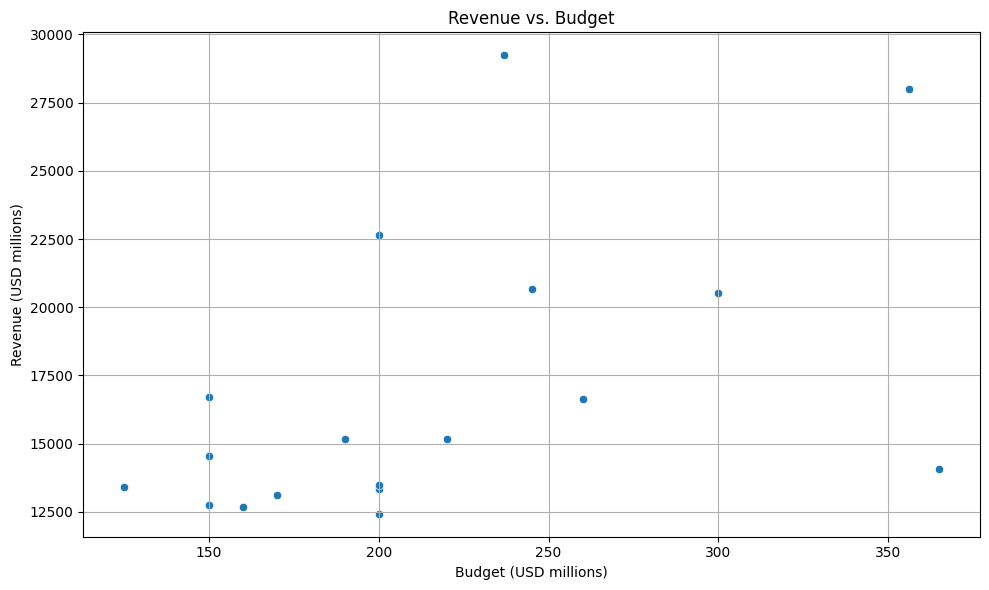

In [52]:
visn.revenue_vs_budget(df)

- ROI Distribution by Genre

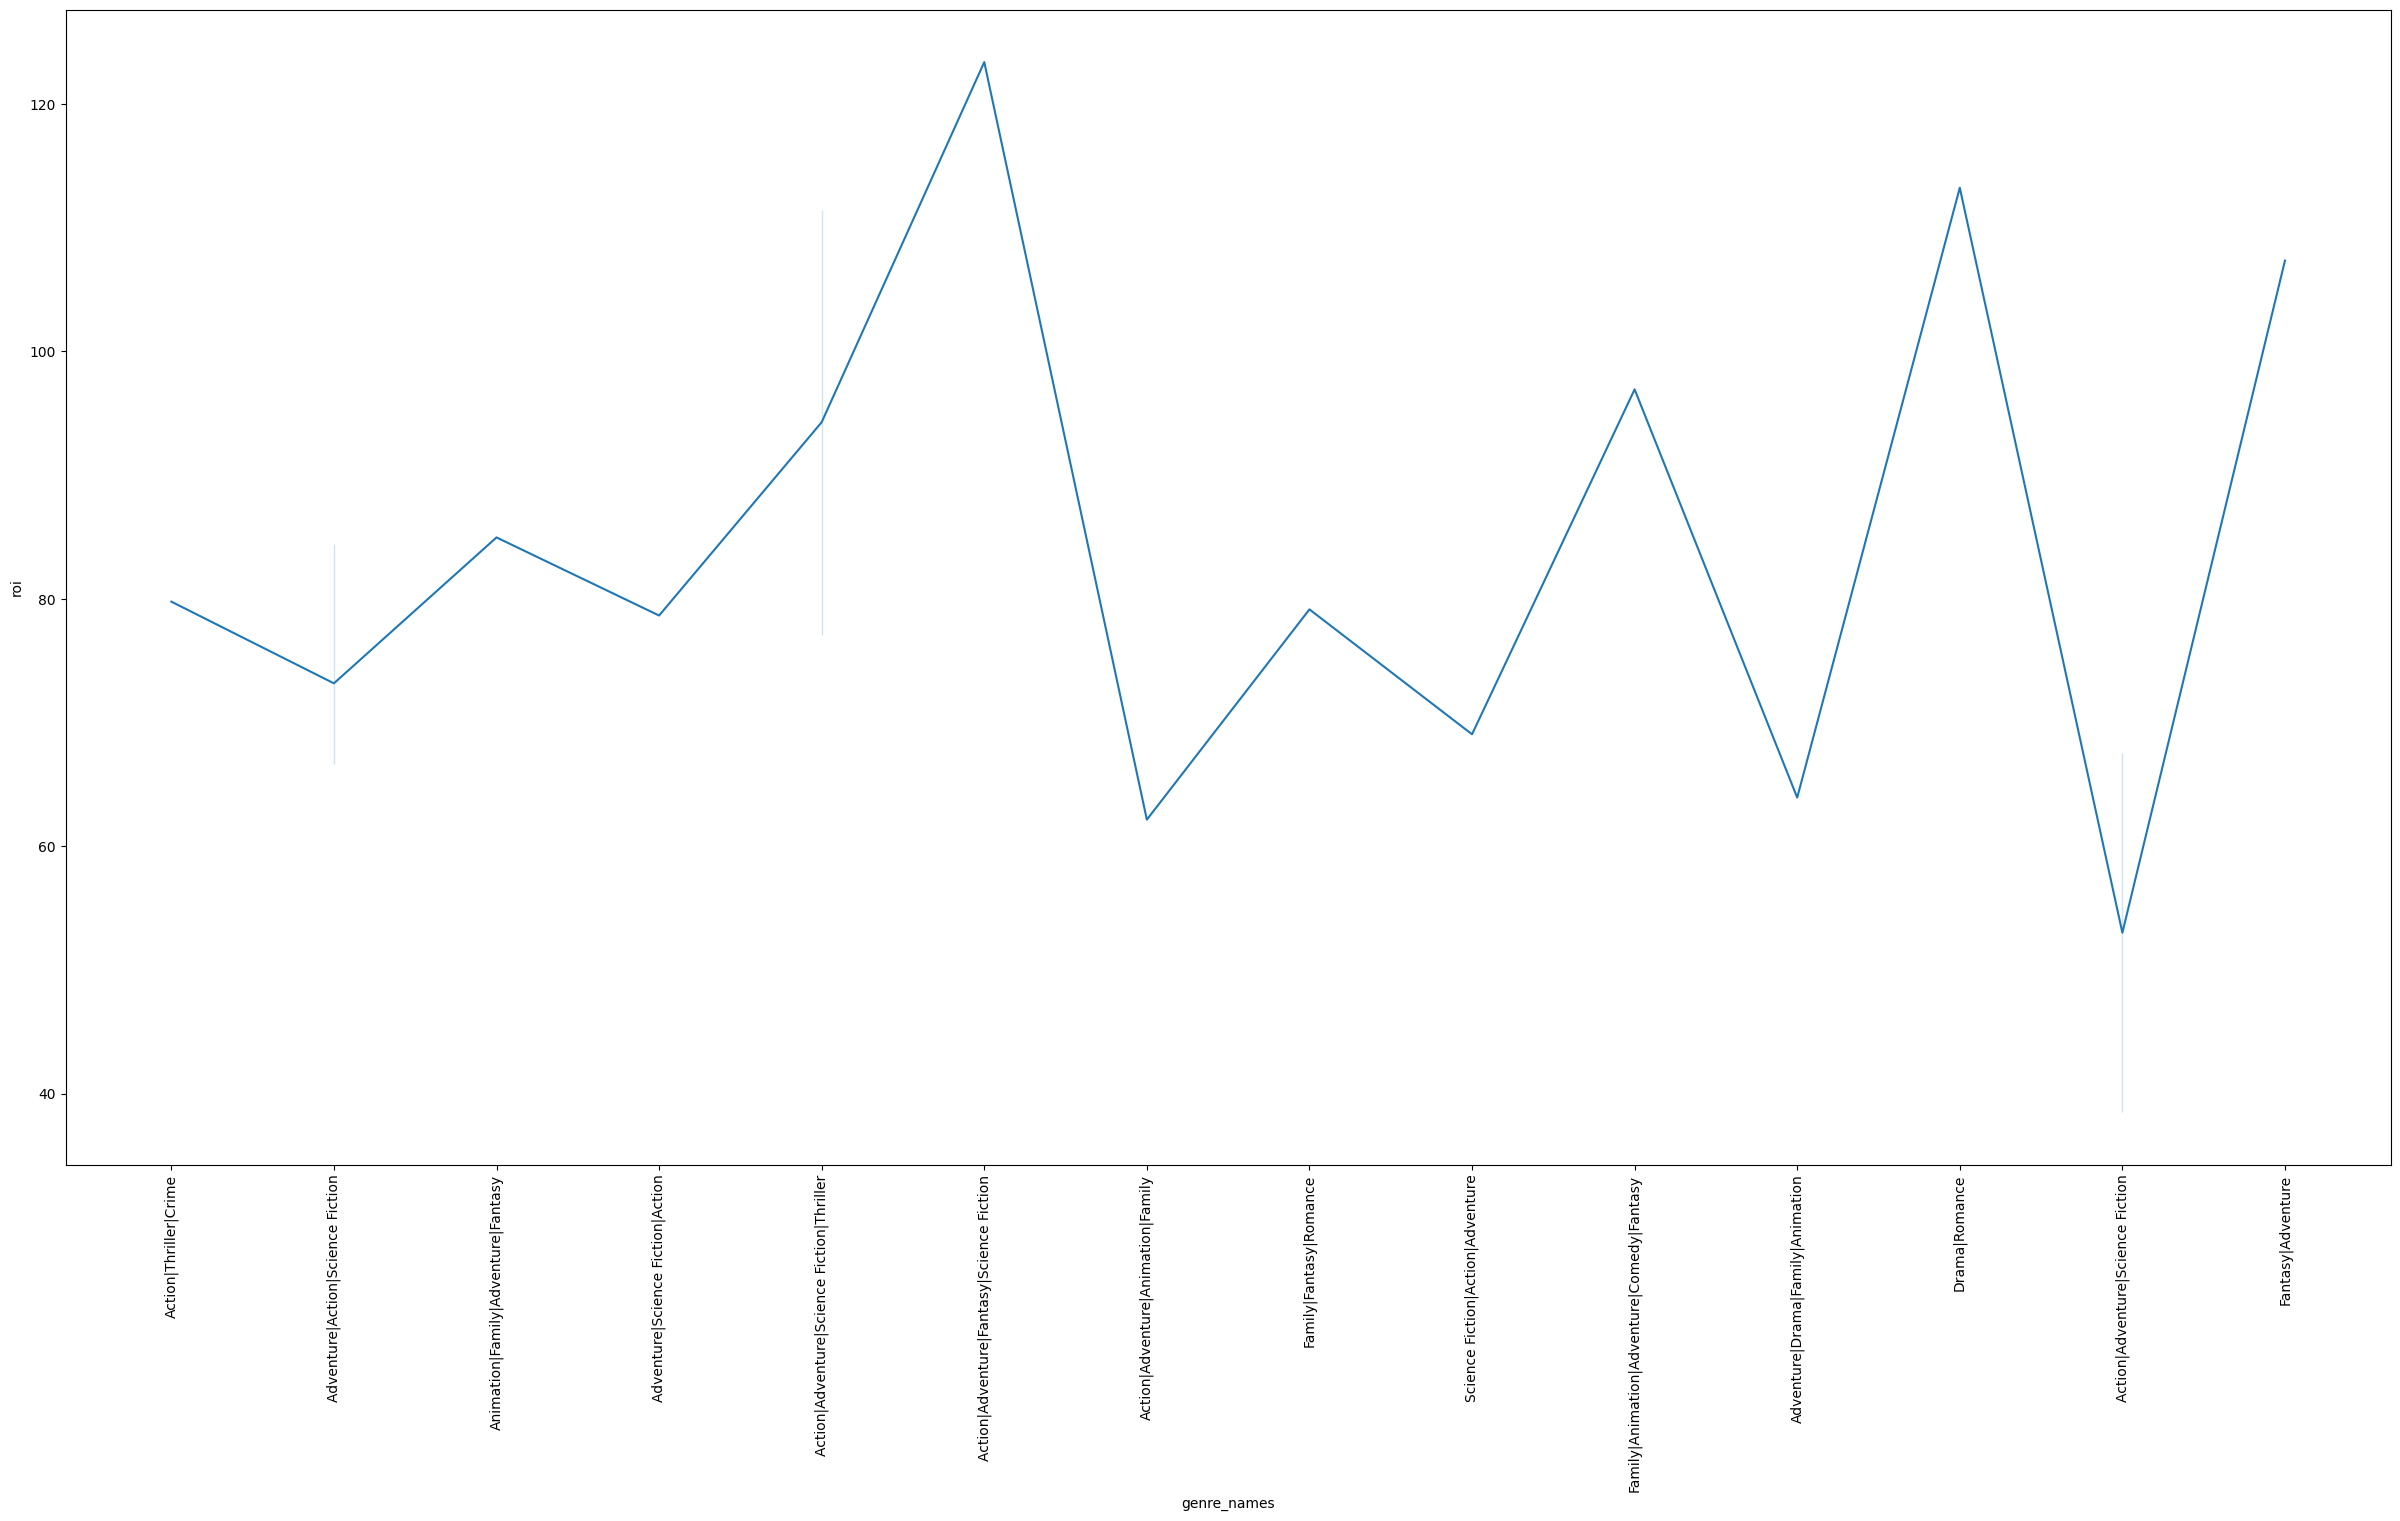

In [53]:
visn.roi_distribution_by_genre(df)

- Popularity vs. Rating

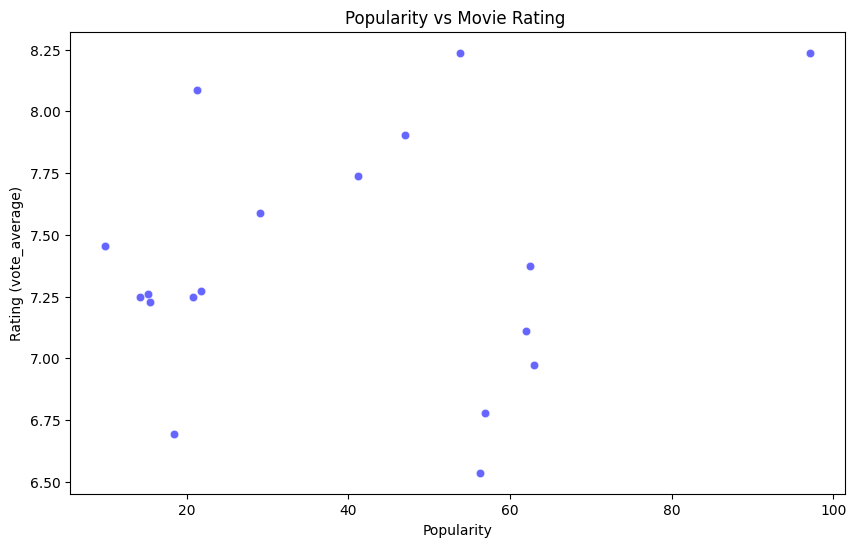

In [54]:
visn.popularity_vs_rating(df)

- Yearly Trends in Box Office Performance

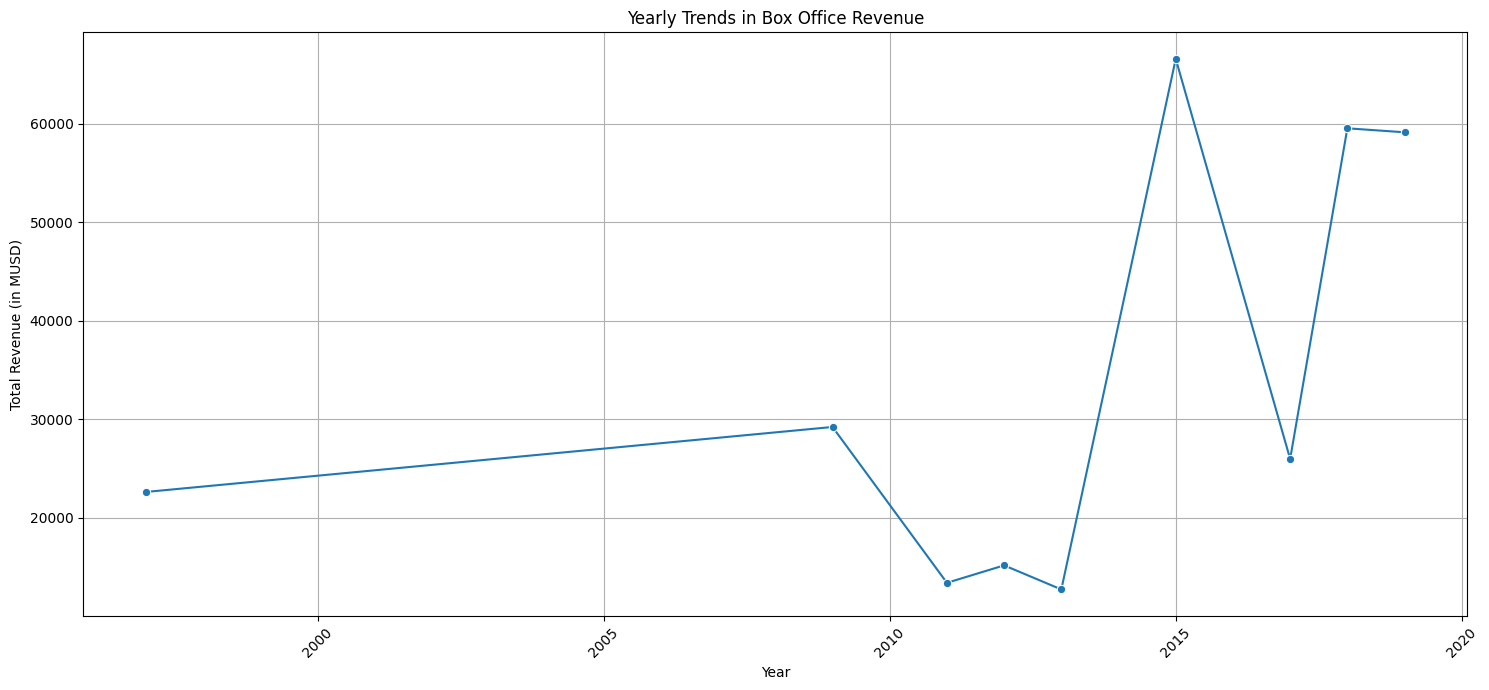

In [55]:
visn.yearly_box_office_performance(df_with_franchise_flag)

- Comparison of Franchise vs. Standalone Success

<Figure size 1200x700 with 0 Axes>

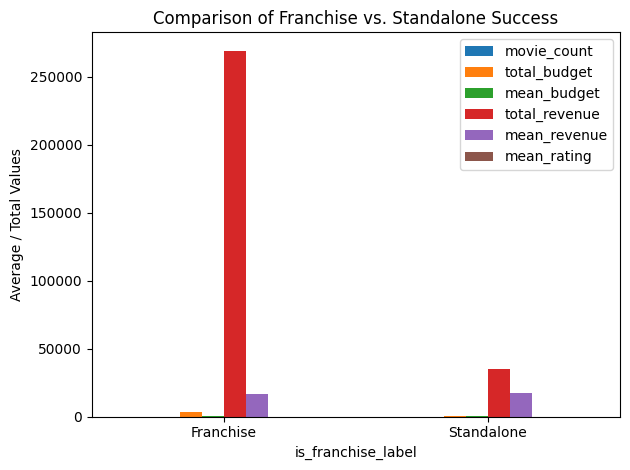

In [56]:
visn.franchise_vs_standalone_success(df_with_franchise_flag)